# About Dataset


Simulated user-aggregated data from an experiment with webpage views and button clicks attributes. Can be very useful for preparing for interviews and practicing statistical tests. The data was prepared using a special selection of parameters: success_rate, uplift, beta, skew

# Loading Data

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('ab_data.csv')

In [2]:
data.head()

,user_id,group,views,clicks
0,1,control,10.0,0.0
1,2,control,1.0,0.0
2,3,control,1.0,0.0
3,4,control,2.0,0.0
4,5,control,3.0,0.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  120000 non-null  int64  
 1   group    120000 non-null  object 
 2   views    120000 non-null  float64
 3   clicks   120000 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 3.7+ MB


In [4]:
data['group'].unique()

array(['control', 'test'], dtype=object)

We have 2 groups: control and test group. Let's split them into two dataframes

In [5]:
control = data[data['group'] == 'control'].copy()
test = data[data['group'] == 'test'].copy()

In [6]:
len(control), len(test)

(60000, 60000)

We also have 2 metrics: views and clicks. Let's calculate the CTR

In [7]:
control['ctr'] = control['clicks'] / control['views']
test['ctr'] = test['clicks'] / test['views']

# CTR

First we got to see if there is any outliers in our groups.

Methods to detect outliers: https://llego.dev/posts/outlier-detection-handling-python-guide/

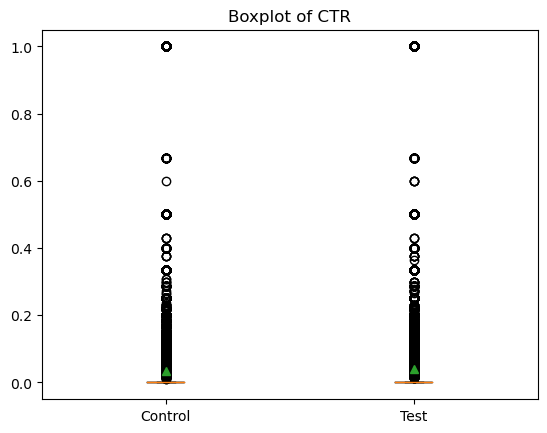

In [8]:
bx = plt.boxplot([control['ctr'], test['ctr']], showmeans=True)
plt.title('Boxplot of CTR')
plt.xticks(labels=['Control', 'Test'], ticks=[1, 2]);

To drop ourliers i will use a standard method called *Standard Deviation Method*

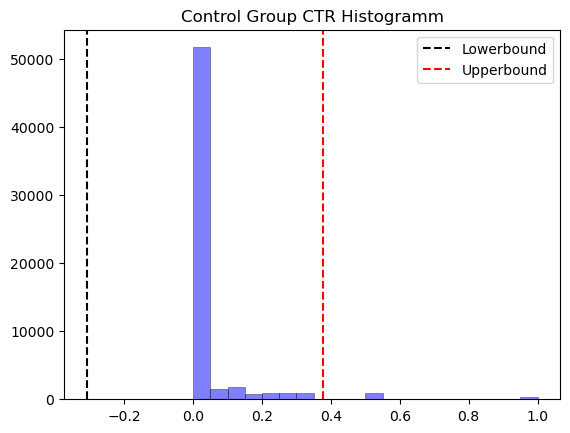

In [9]:
from matplotlib.lines import Line2D

# Control Group Data
threshold = 3
control_mean = control['ctr'].mean()
control_std = control['ctr'].std()

plt.hist(
    control['ctr'],
    color='blue',
    ec='black',
    linewidth=0.5,
    alpha=0.5,
    bins=np.linspace(0, 1, 21)
)
plt.title('Control Group CTR Histogramm')
plt.axvline(control_mean - control_std*threshold, color='black', linestyle='--');
plt.axvline(control_mean + control_std*threshold, color='red', linestyle='--')
handles = [Line2D([0], [0], c='black', linestyle='--'), Line2D([0], [0], c='red', linestyle='--')]
labels = ["Lowerbound", "Upperbound"]
plt.legend(handles, labels);

In [10]:
control_cleaned = control.query(
    '''
    views >= @control_mean - @threshold * @control_std and views <= @control_mean + @threshold * @control_std
    '''
).copy()

In [11]:
control_cleaned = control.query(
    '''
    ctr >= @control_mean - @threshold * @control_std and ctr <= @control_mean + @threshold * @control_std
    '''
).copy()

In [12]:
print('Lenght of Control Data before dropping outliers:', len(control))
print('Lenght of Control Data after dropping outliers:', len(control_cleaned))

Lenght of Control Data before dropping outliers: 60000
Lenght of Control Data after dropping outliers: 58624


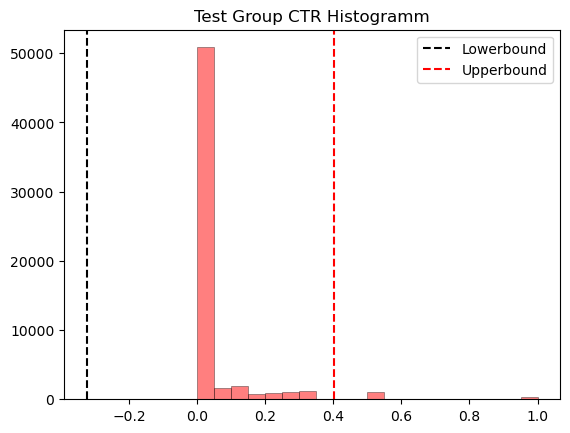

In [13]:
from matplotlib.lines import Line2D

# Test Group Data
threshold = 3
test_mean = test['ctr'].mean()
test_std = test['ctr'].std()

plt.hist(
    test['ctr'],
    color='red',
    ec='black',
    linewidth=0.5,
    alpha=0.5,
    bins=np.linspace(0, 1, 21)
)
plt.title('Test Group CTR Histogramm')
plt.axvline(test_mean - test_std*threshold, color='black', linestyle='--');
plt.axvline(test_mean + test_std*threshold, color='red', linestyle='--')
handles = [Line2D([0], [0], c='black', linestyle='--'), Line2D([0], [0], c='red', linestyle='--')]
labels = ["Lowerbound", "Upperbound"]
plt.legend(handles, labels);

In [14]:
test_cleaned = test.query(
    '''
    ctr >= @test_mean - @threshold * @test_std and ctr <= @test_mean + @threshold * @test_std
    '''
).copy()

In [15]:
print('Lenght of Test Data before dropping outliers:', len(test))
print('Lenght of Test Data after dropping outliers:', len(test_cleaned))

Lenght of Test Data before dropping outliers: 60000
Lenght of Test Data after dropping outliers: 58551


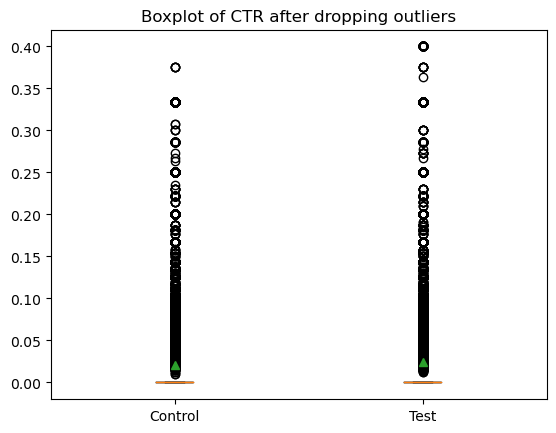

In [16]:
bx = plt.boxplot([control_cleaned['ctr'], test_cleaned['ctr']], showmeans=True)
plt.title('Boxplot of CTR after dropping outliers')
plt.xticks(labels=['Control', 'Test'], ticks=[1, 2]);

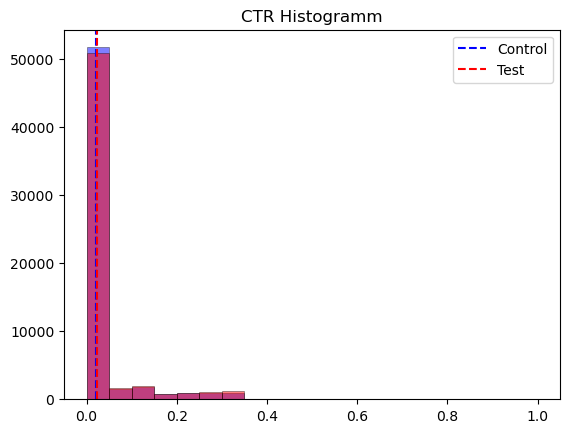

In [17]:
from matplotlib.lines import Line2D

plt.hist(
    control_cleaned['ctr'],
    color='blue',
    ec='black',
    linewidth=0.5,
    alpha=0.5,
    bins=np.linspace(0, 1, 21)
)
plt.hist(
    test_cleaned['ctr'],
    color='red',
    ec='black',
    linewidth=0.5,
    alpha=0.5,
    bins=np.linspace(0, 1, 21)
)
plt.title('CTR Histogramm')
plt.axvline(control_cleaned['ctr'].mean(), color='blue', linestyle='--')
plt.axvline(test_cleaned['ctr'].mean(), color='red', linestyle='--')
handles = [Line2D([0], [0], c='blue', linestyle='--'), Line2D([0], [0], c='red', linestyle='--')]
labels = ["Control", 'Test']
plt.legend(handles, labels);

In [18]:
print('Control Group Mean CTR:', control_cleaned['ctr'].mean())
print('Test Group Mean CTR:', test_cleaned['ctr'].mean())

Control Group Mean Views: 0.020881977230953284
Test Group Mean Views: 0.023856738642646633


In [37]:
print('Control Group Std of CTR:', control_cleaned['ctr'].std())
print('Test Group Std of CTR:', test_cleaned['ctr'].std())

Control Group Std of CTR: 0.06375254386354962
Test Group Std of CTR: 0.06883269489296398


In [44]:
# Test for normal distribution

s, p = st.shapiro(control_cleaned['ctr'])
if p < 0.05:
    print('Sample does not come from a normal distribution')
else:
    print('Sample come from a normal distribution')

Sample does not come from a normal distribution


**Criterion Choosing:** Our sample does not come from a normal distribution, so we can't use T-Test. But we can use MannWhitneyu Test.

# Hypothesis Testing

- *H0* - No significant difference between the test group and the control group in CTR

- *H1* - Significant difference between the test group and the control group in CTR

## MannWhitneyu test

In [45]:
s, p = st.mannwhitneyu(control_cleaned['ctr'], test_cleaned['ctr'])

if p < 0.05:
    print('Reject Null Hypothesis')
else:
    print('Do not reject null hypothesis')

Reject Null Hypothesis


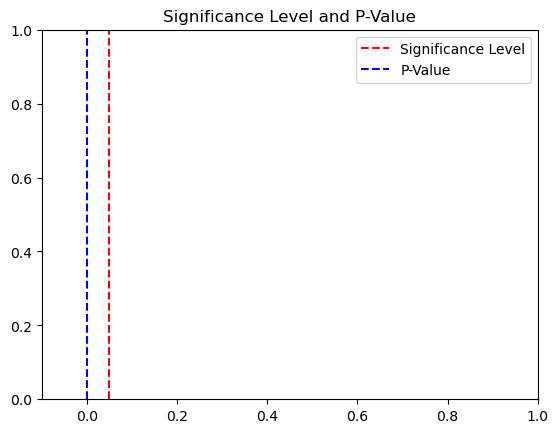

In [46]:
plt.title('Significance Level and P-Value')
# plt.axvline(0.05)
plt.axvline(0.05, color='red', linestyle='--')
plt.axvline(p, color='blue', linestyle='--')
handles = [Line2D([0], [0], c='red', linestyle='--'), Line2D([0], [0], c='blue', linestyle='--')]
labels = ["Significance Level", 'P-Value']
plt.legend(handles, labels);
plt.xlim([-0.1, 1]);

# Conclusion

Null Hypothesis was rejectred. We have enough evidence to say that the null hypothesis is not True and our alternarive hypothesis (*H1*) is most likely True. So we can say that experiment has increased the CTR metrics in the test group.

In [48]:
print('Control Group Mean CTR:', control_cleaned['ctr'].mean())
print('Test Group Mean CTR:', test_cleaned['ctr'].mean())

Control Group Mean CTR: 0.020881977230953284
Test Group Mean CTR: 0.023856738642646633
